In [1]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm # For a nice progress bar
from exactextract import exact_extract

In [2]:
# --- 2. Define Project Paths ---
PROJECT_ROOT = Path("../")
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
GIS_DATA_DIR = PROJECT_ROOT / "data" / "gis"

# Input file paths for the clipped data
CLIPPED_FILES = {
    'pr': PROCESSED_DATA_DIR / "chittenden_pr_clipped.nc",
    'tasmax': PROCESSED_DATA_DIR / "chittenden_tasmax_clipped.nc",
    'tasmin': PROCESSED_DATA_DIR / "chittenden_tasmin_clipped.nc",
}
SHAPEFILE_PATH = GIS_DATA_DIR / "Chittenden_catchment.shp"

print(f"Reading processed data from: {PROCESSED_DATA_DIR}")

Reading processed data from: ..\data\processed


In [3]:
# --- 3. Load Shapefile and Clipped Datasets ---

# Load the basin shapefile
try:
    basin_gdf = gpd.read_file(SHAPEFILE_PATH)
    # The CRS of the shapefile is needed for exactextract to work correctly
    # Since our rasters are in WGS84 (EPSG:4326), we ensure the shapefile is too.
    if basin_gdf.crs.to_epsg() != 4326:
        print("Reprojecting shapefile to EPSG:4326 for analysis...")
        basin_gdf = basin_gdf.to_crs("EPSG:4326")
    print("Shapefile loaded and projected successfully.")
except Exception as e:
    print(f"Error loading shapefile: {e}")

# Load the clipped datasets into a dictionary
datasets = {}
for var, path in CLIPPED_FILES.items():
    try:
        datasets[var] = xr.open_dataset(path)
        print(f"Loaded {path.name}")
    except Exception as e:
        print(f"Error loading {path.name}: {e}")

Reprojecting shapefile to EPSG:4326 for analysis...
Shapefile loaded and projected successfully.
Loaded chittenden_pr_clipped.nc
Loaded chittenden_tasmax_clipped.nc
Loaded chittenden_tasmin_clipped.nc


In [4]:
# --- 4. Define the Weighted Average Calculation Function (Final, Corrected Accessor) ---

def calculate_weighted_average_timeseries(ds: xr.Dataset, gdf: gpd.GeoDataFrame, var_name: str) -> pd.Series:
    """
    Calculates the area-weighted average of a raster variable. This definitive version
    correctly accesses the nested 'mean' value from the GeoJSON-style output of exact_extract.

    Args:
        ds (xr.Dataset): The xarray Dataset to analyze.
        gdf (gpd.GeoDataFrame): The GeoDataFrame with polygons (in EPSG:4326).
        var_name (str): The name of the data variable in the dataset (e.g., 'pr').

    Returns:
        pd.Series: A pandas time series of the weighted average values.
    """
    
    data_array = ds[var_name]
    daily_averages = []

    # Create a version of the GeoDataFrame in a projected CRS for accurate area calculation
    gdf_projected = gdf.to_crs("EPSG:26910") 

    print(f"\nCalculating weighted average for '{var_name}'...")
    for time_step in tqdm(data_array['time']):
        daily_slice = data_array.sel(time=time_step)

        # Add spatial metadata directly to the slice inside the loop
        daily_slice.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
        daily_slice.rio.write_crs("EPSG:4326", inplace=True)

        # The extraction uses the GDF in the raster's CRS (EPSG:4326)
        results = exact_extract(daily_slice, gdf, ['mean'])
        
        total_area = gdf_projected.geometry.area.sum()
        
        # --- THIS IS THE FINAL FIX ---
        # Access the mean value nested inside the 'properties' dictionary.
        # Use .get('properties', {}) to safely handle empty results, then .get('mean')
        basin_wide_mean = sum(
            (r.get('properties', {}).get('mean') or 0) * area
            for r, area in zip(results, gdf_projected.geometry.area)
        ) / total_area
        # ------------------------------------------------------------
        
        daily_averages.append(basin_wide_mean)

    timeseries = pd.Series(daily_averages, index=ds['time'].values, name=var_name)
    
    return timeseries

In [5]:
# --- 5. Run Analysis for All Variables ---

# Create an empty DataFrame to hold all the time series results
basin_analysis_df = pd.DataFrame()

for var, ds in datasets.items():
    # Calculate the time series for the current variable
    timeseries = calculate_weighted_average_timeseries(ds, basin_gdf, var)
    
    # Add the result as a new column in our DataFrame
    basin_analysis_df[var] = timeseries

print("\n--- Basin-Wide Weighted Average Time Series ---")
print(basin_analysis_df.head())

# Save the final results to a CSV for future use
output_csv_path = PROCESSED_DATA_DIR / "chittenden_basin_daily_averages.csv"
basin_analysis_df.to_csv(output_csv_path)
print(f"\nResults saved to {output_csv_path}")


Calculating weighted average for 'pr'...


  0%|          | 0/293 [00:00<?, ?it/s]


Calculating weighted average for 'tasmax'...


  0%|          | 0/293 [00:00<?, ?it/s]


Calculating weighted average for 'tasmin'...


  0%|          | 0/293 [00:00<?, ?it/s]


--- Basin-Wide Weighted Average Time Series ---
                  pr    tasmax    tasmin
1953-12-12  8.183246  4.431120 -3.860412
1953-12-13  1.661795  0.860373 -7.303835
1953-12-14  5.710673  2.247344 -5.375595
1953-12-15  0.000000 -0.943555 -8.745102
1953-12-16  0.000000  1.311886 -5.434699

Results saved to ..\data\processed\chittenden_basin_daily_averages.csv



Generating summary plots...


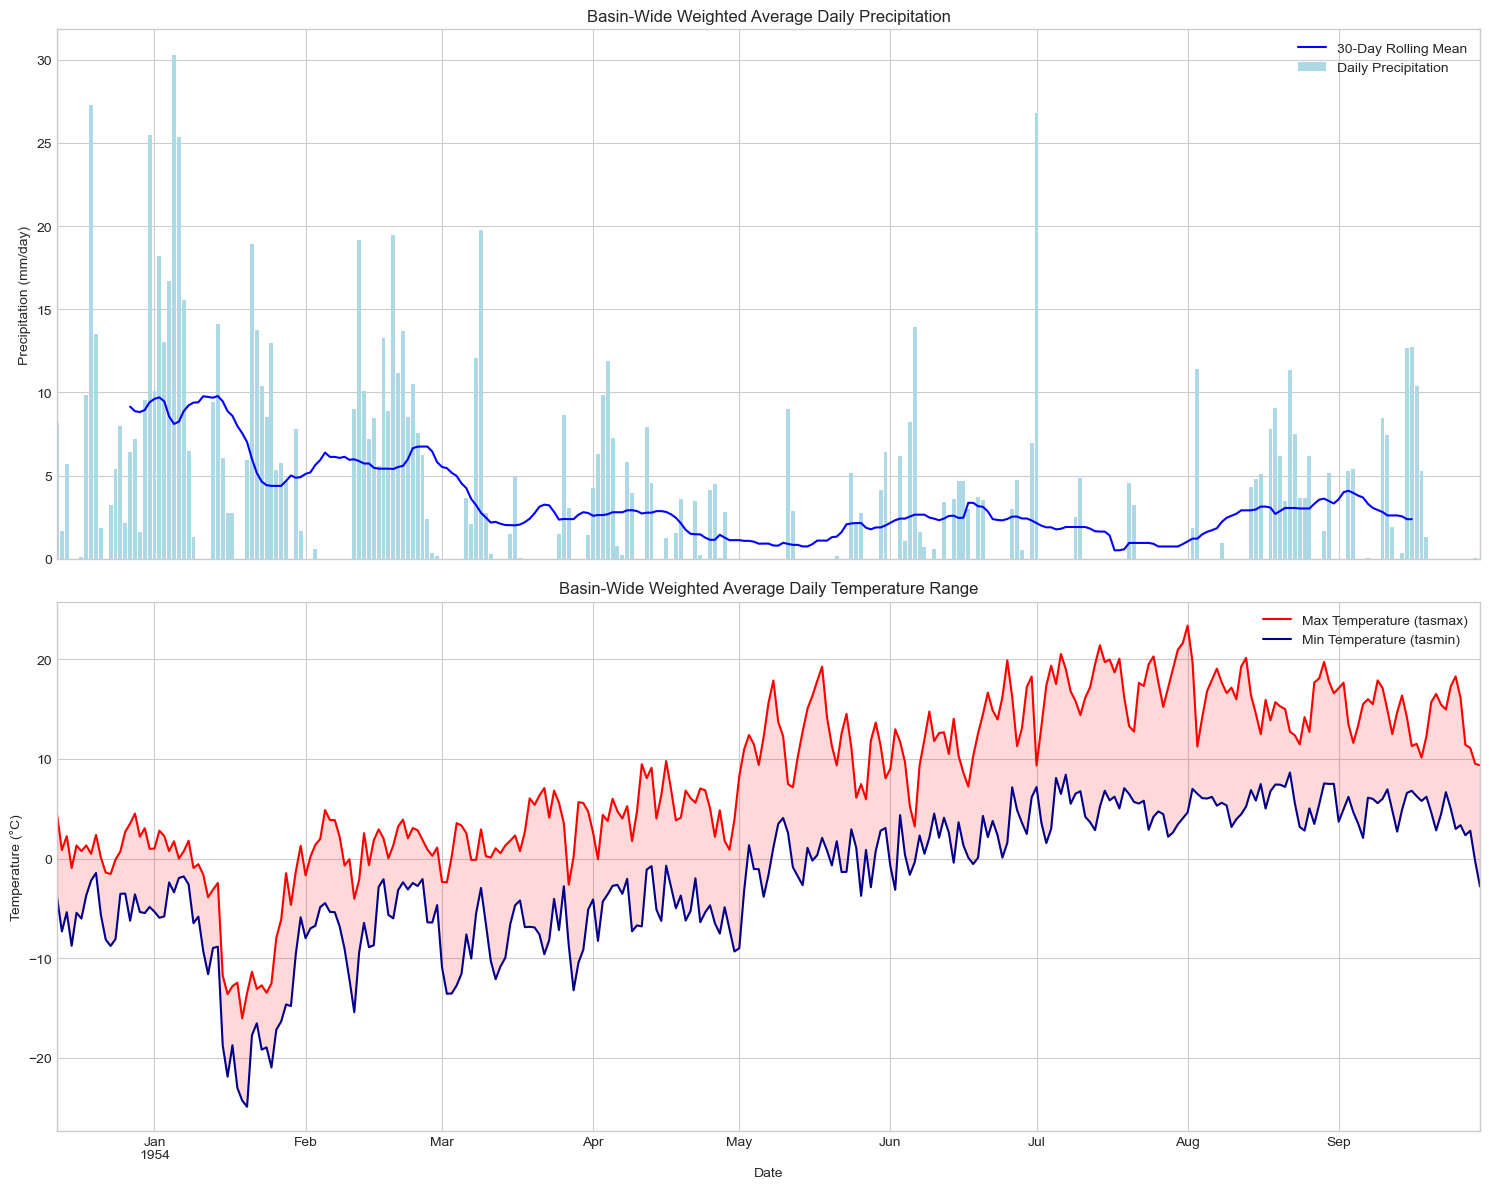

In [7]:
# --- 6. Visualize the Results ---

print("\nGenerating summary plots...")

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# --- Plot 1: Precipitation ---
# Plot daily precipitation as bars
ax1.bar(basin_analysis_df.index, basin_analysis_df['pr'], color='lightblue', label='Daily Precipitation')

# Plot a 30-day rolling average to show trends
basin_analysis_df['pr'].rolling(30, center=True).mean().plot(ax=ax1, color='blue', label='30-Day Rolling Mean')

ax1.set_ylabel("Precipitation (mm/day)")
ax1.set_title("Basin-Wide Weighted Average Daily Precipitation")
ax1.legend()

# --- Plot 2: Temperature ---
# Plot min and max temperature lines
ax2.plot(basin_analysis_df.index, basin_analysis_df['tasmax'], color='red', label='Max Temperature (tasmax)')
ax2.plot(basin_analysis_df.index, basin_analysis_df['tasmin'], color='darkblue', label='Min Temperature (tasmin)')

# Fill the area between min and max to show the daily temperature range
ax2.fill_between(basin_analysis_df.index, basin_analysis_df['tasmin'], basin_analysis_df['tasmax'], color='red', alpha=0.15)

ax2.set_ylabel("Temperature (°C)")
ax2.set_title("Basin-Wide Weighted Average Daily Temperature Range")
ax2.set_xlabel("Date")
ax2.legend()

plt.tight_layout()
plt.show()